# Recurrent Neural Network (RNN)

This module demonstrates the implementation of a simple RNN using PyTorch. It generates synthetic sequential data, trains the RNN model, and evaluates its predictions.

Authors: Pierre Lepetit and Rachid El Montassir

In [1]:
from PIL import Image
import os
if not os.path.exists("rnn.png"):
  ! git clone https://github.com/relmonta/ml-student.git
  ! mv ml-student/TP4/*.png .
  ! mv ml-student/TP4/*.csv .

Cloning into 'ml-student'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 263 (delta 99), reused 111 (delta 74), pack-reused 117
Receiving objects: 100% (263/263), 14.56 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (112/112), done.


## What are RNNs?

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed to process sequential data. Unlike traditional feedforward neural networks, which process the entire input independently, RNNs maintain a hidden state that captures information about the input seen so far. This hidden state is updated at each time step, allowing RNNs to retain information about the context of the sequence.

RNNs are well-suited for tasks involving sequences, such as time series analysis, natural language processing, speech recognition, and more. They process inputs one step at a time, maintaining an internal state that captures information about the sequence.

RNNs share the same set of parameters across all time steps. This parameter sharing allows the network to learn and generalize patterns from one part of the sequence to another. It is particularly useful when dealing with sequences of varying lengths.

## Structure of an RNN block:

The basic structure of an RNN block involves the following components:

#### Input:

- **X(t):** Input at time step t.

#### Hidden State:

- **H(t):** Hidden state at time step t.
- **H(t-1):** Hidden state from the previous time step.

The hidden state of an RNN block serves as its memory, allowing it to capture information from previous time steps and use it to influence future predictions.
#### Output:

- **H(t):** The module implemented in PyTorch considers the hidden state as the output at time step t, and also computed as follows :

$$H(t) = tanh(W_{hh} \cdot H(t-1) + W_{xh} \cdot X(t) + b_h)$$

where:
- $(W_{hh})$ and $( W_{xh} )$ are weight matrices.
- $(b_h)$ and $( b_y )$ are bias vectors.


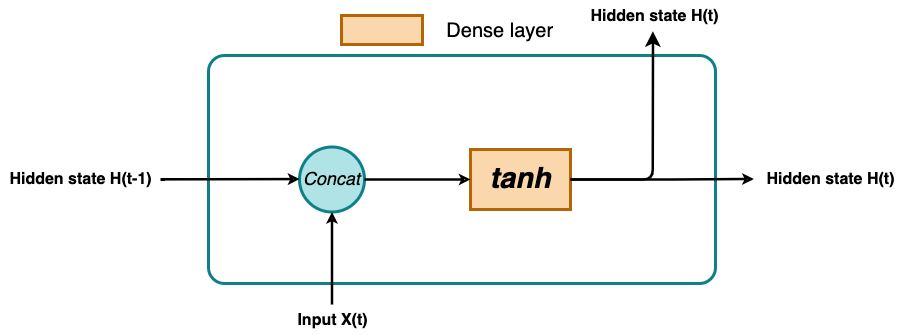

In [2]:
Image.open("rnn.png")

**Note:** There are other implementations depending on the task and input features, and the output can be different from the hidden state.
## RNN network:

- **X:** The input sequence.
- **H:** The concatenated hidden states.


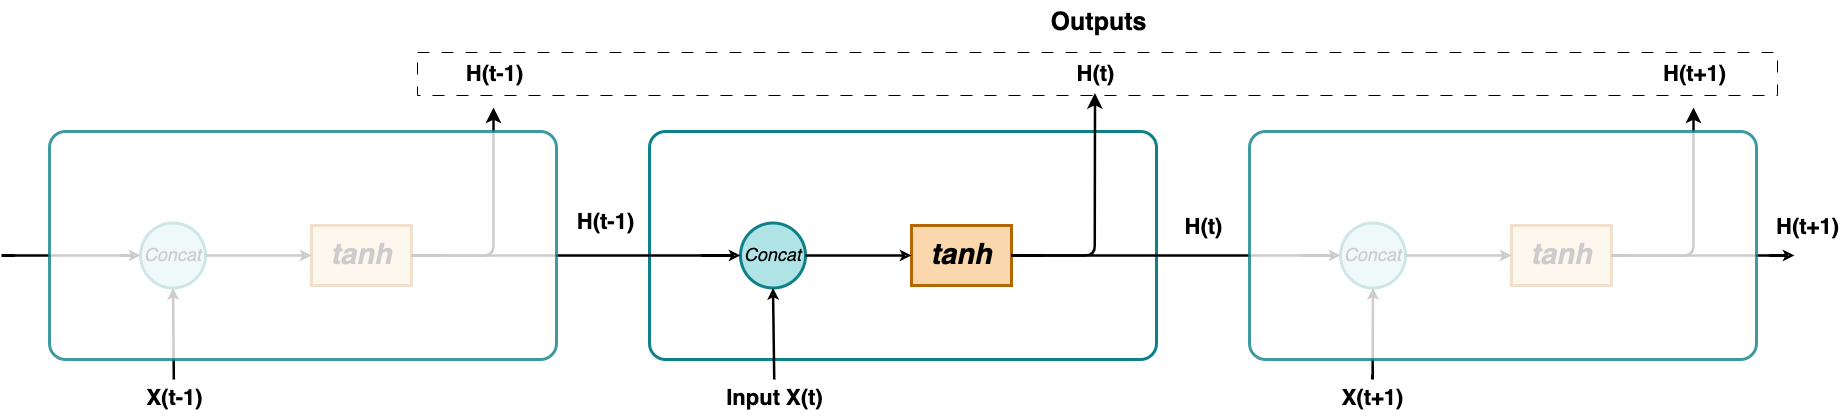

In [3]:
Image.open("rnn_network.png")

## Challenges:

While RNNs have proven effective for many sequence-based tasks, they suffer from challenges such as vanishing gradients and difficulties in capturing long-term dependencies. To address these issues, more advanced RNN architectures, such as Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs), have been developed.

In summary, Recurrent Neural Networks are powerful for modelling sequential data. Their ability to capture temporal dependencies makes them indispensable in applications ranging from natural language processing to time series prediction.

In [4]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generating synthetic sequential data

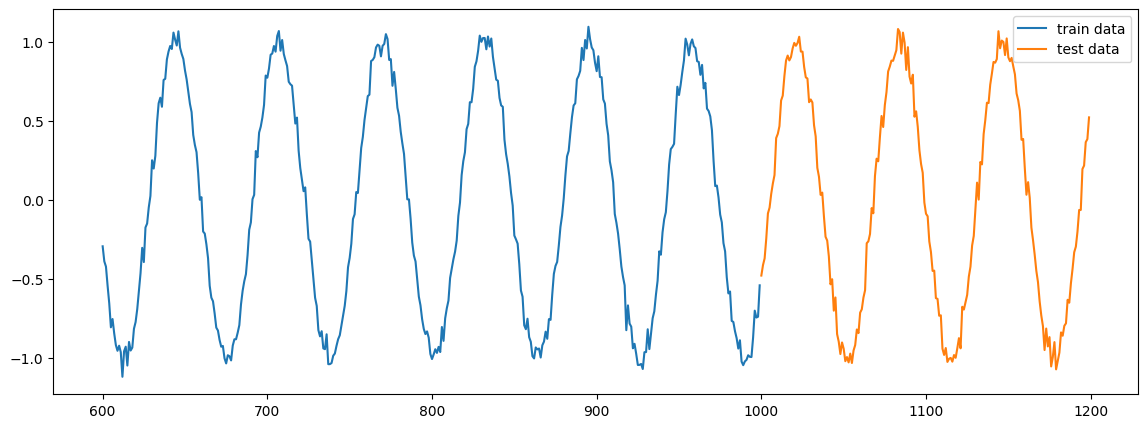

In [6]:
noise_scale = 5e-2
data = np.sin(np.arange(0, 200, 0.1)) + np.random.normal(0, noise_scale, 2000)
split_at = 1000
train_data = data[:split_at]
test_data = data[split_at:]

start_plot = 600
stop_plot = 1200
plt.figure(figsize=(14,5))
plt.plot(range(start_plot, split_at),data[start_plot:split_at],label="train data")
plt.plot(range(split_at, stop_plot),test_data[:stop_plot-split_at],label="test data")
plt.legend()
plt.show()
# Converting data to PyTorch tensor
train_data = torch.FloatTensor(train_data).view(-1, 1)
test_data = torch.FloatTensor(test_data).view(-1, 1)

# Dataset

In [7]:
class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for the time series data.
    """

    def __init__(self, data, input_sequence_len, output_size=1):
        self.data = data
        self.input_sequence_len = input_sequence_len
        self.output_size = output_size

    def __len__(self):
        return len(self.data) - self.input_sequence_len - self.output_size

    def __getitem__(self, start_idx):
        # Extracting a sequence of data
        stop_idx = start_idx + self.input_sequence_len
        sequence = self.data[start_idx:stop_idx]
        # Target is the next value in the sequence
        target = self.data[stop_idx:stop_idx + self.output_size]
        return {'sequence': sequence, 'target': target}

# Simple Perceptron (fully connected) network

**Exercise 1**: We start by implement a simple fully connected model.

Implement a fully connected model using an input layer and a hidden layer.

In [15]:
class SimpleFC(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFC, self).__init__()
        # YOUR CODE HERE
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        #raise NotImplementedError()

    def forward(self, x):
        out = self.fc1(x.squeeze(-1))
        out = self.fc(out)
        return out

# Training

**Exercise 2**: Implement the train loop (use GPU).

In [23]:
from tqdm import tqdm
import time
def train(model, dataloader, learning_rate=0.001, epochs=100, device=device):
    """
    Trains a Recurrent model.

    Args:
    - model (nn.Module): model to be trained.
    - dataloader (DataLoader): DataLoader for the training data.
    - learning_rate (float): Learning rate, default to 1e-3.
    - epochs (int): Number of training epochs.
    - device (str): Device to use ('cuda' for GPU, 'cpu' for CPU).

    Returns:
    - model (nn.Module): Trained model.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    since = time.time()
    model = model.to(device)
    losses = []
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        # zero_grad = mettre le gradient à zéro à chaque fois (mai on pourri tl'enlever et faire un if, et si )
        for batch in dataloader:

            optimizer.zero_grad()
            outputs = model(batch["sequence"].to(device))

            # loss and compuation of gradients
            loss = criterion(outputs, batch["target"].to(device).squeeze(-1))  # Compute the loss
            loss.backward()  # Backward pass

            # Update weights
            optimizer.step()  # Update the weights
            epoch_loss += loss.item()

        # YOUR CODE HERE
        losses.append(epoch_loss / len(dataloader))
    print(f"\nTotal time :{(time.time()-since):.1f} s")
    return model,losses

def plot_loss(losses):
  plt.figure(figsize=(14, 5))
  plt.plot(range(2, len(losses) + 1), losses[1:],linewidth=2, color='b')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Model Losses Over Epochs')
  plt.grid(True)
  plt.show()

In [24]:
input_sequence_len = 20
output_size = 3

dataset = TimeSeriesDataset(train_data, input_sequence_len, output_size=output_size)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

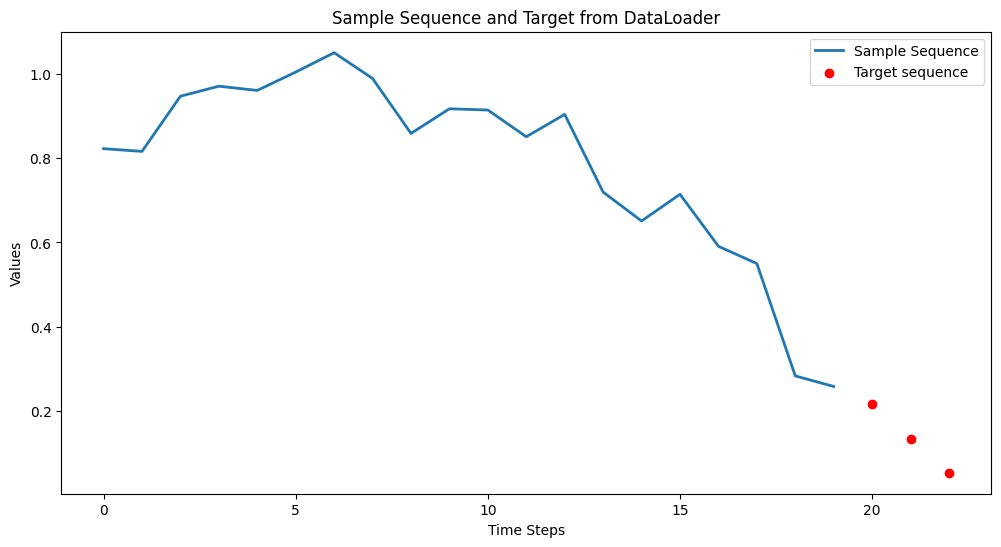

In [25]:
# Plot a sample sequence and target from the DataLoader
sample_batch = next(iter(dataloader))
sample_sequence = sample_batch['sequence'][0].numpy()
sample_target = sample_batch['target'][0].numpy()

plt.figure(figsize=(12, 6))
plt.plot(sample_sequence, linewidth=2, label='Sample Sequence')
plt.scatter(input_sequence_len + 0, sample_target[0], color='red', label='Target sequence')
for i in range(1,output_size):
    plt.scatter(input_sequence_len + i, sample_target[i], color='red')
plt.legend()
plt.title('Sample Sequence and Target from DataLoader')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

100%|██████████| 100/100 [00:06<00:00, 16.42it/s]



Total time :6.1 s


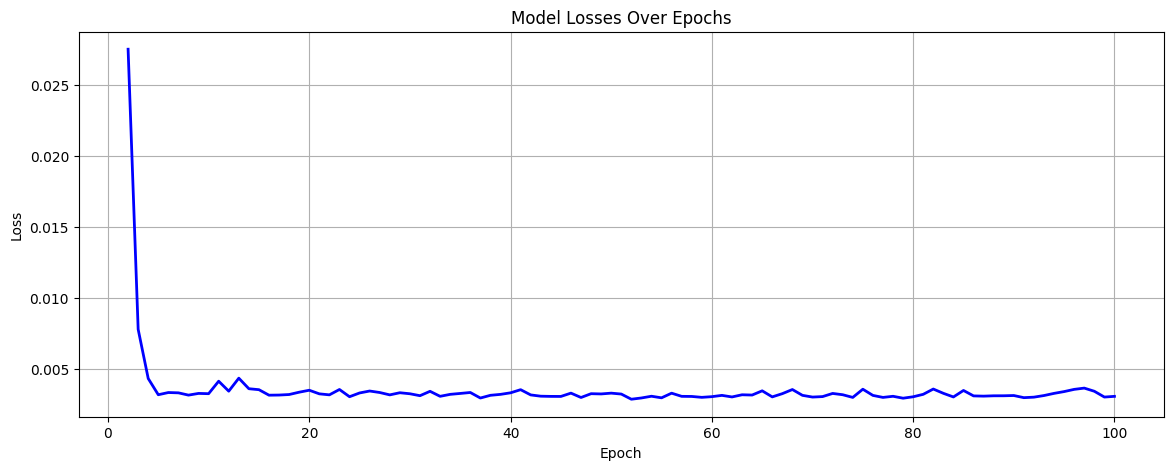

In [26]:
input_size = input_sequence_len
hidden_size = 512
epochs = 100

fc_model = SimpleFC(input_size, hidden_size, output_size)

trained_fc_model,fc_losses = train(fc_model, dataloader, learning_rate=0.01, epochs=epochs)
plot_loss(fc_losses)

# Evaluating the model

In [27]:
def evaluate_model(model, data, input_sequence_len, future_steps,output_size, device=device):
    """
    Evaluates the given model by making predictions for future time steps.

    Args:
    - model (nn.Module): Trained model to be evaluated.
    - data (torch.Tensor): Input data for evaluation.
    - input_sequence_len (int): Length of the input sequence.
    - future_steps (int): Number of future time steps to predict.
    - device (str): Device to use ('cuda' for GPU, 'cpu' for CPU).

    Returns:
    - predictions (torch.Tensor): Predicted values for future time steps.
    - errors (torch.Tensor): Errors for each time step.
    """
    with torch.no_grad():
        model.eval()
        # Generating a sequence for evaluation
        eval_sequence = data[-input_sequence_len:].view(1, -1, 1).to(device)
        # Making predictions for the future time steps
        predictions = eval_sequence.clone().squeeze(-1)
        for i in range(0,future_steps,output_size):
            pred = model(eval_sequence[:, i:, :])
            eval_sequence = torch.cat([eval_sequence, pred.unsqueeze(-1)], dim=1)
            predictions = torch.cat([predictions, pred], dim=1)

        predictions = predictions.cpu()
        print(predictions.shape)
        print(test_data.shape)
        errors = (predictions[:,input_sequence_len:input_sequence_len +
                              future_steps].view(-1) - test_data[:future_steps].view(-1))**2

    return predictions[:,input_sequence_len:input_sequence_len + future_steps], errors.numpy()

In [28]:
future_steps = 200
fc_predictions, fc_errors = evaluate_model(trained_fc_model, train_data, input_sequence_len, future_steps,output_size)

torch.Size([1, 221])
torch.Size([1000, 1])


In [29]:
# Plotting the results
def plot_predictions(predictions,title):
    plt.figure(figsize=(14, 5))
    plt.plot(np.arange(start_plot,len(train_data)), train_data[start_plot:].numpy(), 'g--',label='Training data',linewidth=2)
    plt.plot(np.arange(len(train_data) - input_sequence_len, len(train_data)), train_data[-input_sequence_len:].numpy(),'r--',label='Input sequence',linewidth=2)
    plt.plot(np.arange(len(train_data), len(train_data) + future_steps), test_data[:future_steps].view(-1).numpy(),'--', label='Test sequence',linewidth=2)
    plt.plot(np.arange(len(train_data), len(train_data) + future_steps), predictions.view(-1).numpy(),'orange', label='Predicted sequence',linewidth=2)
    plt.legend()
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()

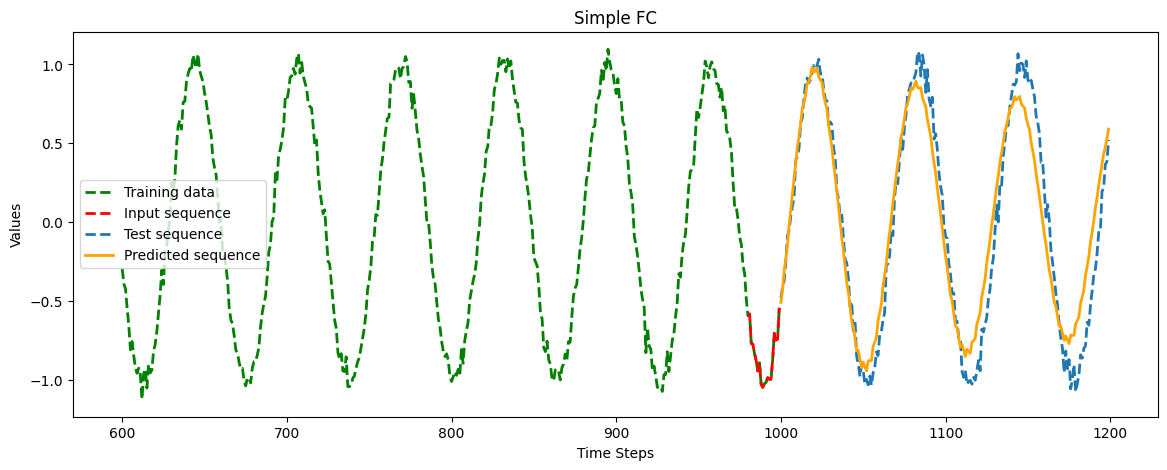

In [30]:
plot_predictions(fc_predictions,'Simple FC')

# Setting up the RNN model

**Exercise 3**: Replace the dense layer used in the last model by an RNN layer.


In [34]:
class SimpleRNN(nn.Module):
    """
    Simple Recurrent Neural Network (RNN) model class.

    Args:
    - input_size (int): Number of input features.
    - hidden_size (int): Number of hidden units in the RNN layer.
    - output_size (int): Number of output features.

    Attributes:
    - rnn (nn.RNN): RNN layer.
    - fc (nn.Linear): Fully connected layer for output.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) # hidden_size, le nomber de Dense
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

100%|██████████| 100/100 [00:04<00:00, 22.23it/s]



Total time :5.0 s


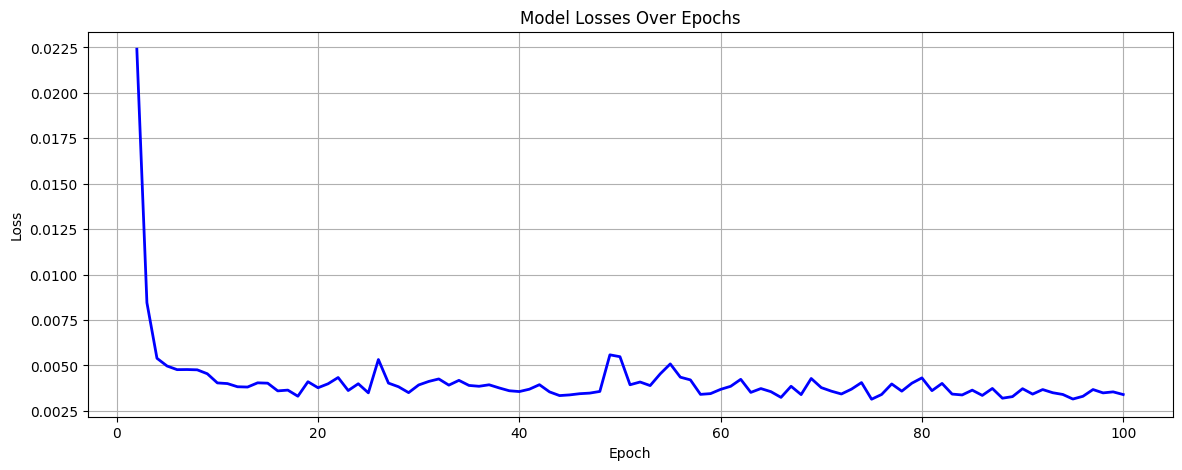

In [35]:
input_size = 1
hidden_size = 32

rnn_model = SimpleRNN(input_size, hidden_size, output_size)

trained_rnn_model,rnn_losses = train(rnn_model, dataloader, learning_rate=0.01, epochs=epochs)
plot_loss(rnn_losses)

In [36]:
future_steps = 200
rnn_predictions, rnn_errors = evaluate_model(trained_rnn_model, train_data, input_sequence_len, future_steps,output_size)

torch.Size([1, 221])
torch.Size([1000, 1])


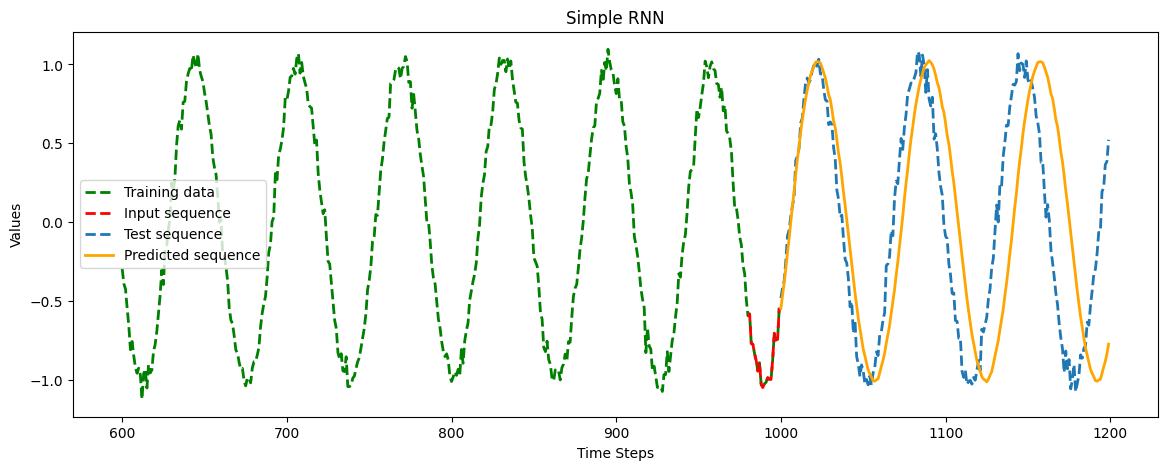

In [37]:
plot_predictions(rnn_predictions,'Simple RNN')

# Long Short-Term Memory (LSTM)
In RNNs, the hidden state acts as a memory, but it tends to lose information over time due to the recurrent nature of the network.
LSTMs introduce a memory cell that can store and retrieve information over long periods. The cell state allows LSTMs to maintain a more stable memory of past inputs.

Standard RNNs suffer from the vanishing and exploding gradient problems, which make it difficult for them to capture and propagate information across long sequences. As the sequence length increases, RNNs struggle to remember information from earlier time steps.
LSTMs were specifically designed to address the vanishing gradient problem. The architecture uses memory cell and gating mechanisms that allow it to selectively remember or forget information over long sequences. This enables LSTMs to capture dependencies over extended time horizons compared to RNNs.

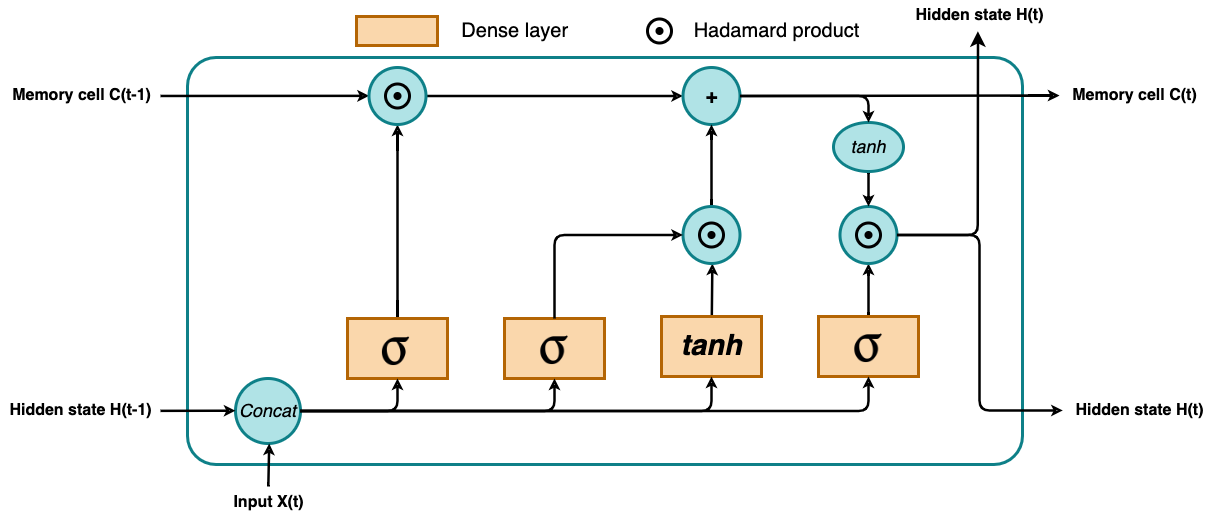

In [38]:
Image.open("lstm.png")

## premiere colonne : enlever informatoin de la mémoire
## deuxime et troisième : ajouer de l'informatoin à la cellule mémoire

# produit hadamard : prodiut élément par élément

# pour le hidden state suivant, sigmoid et hadamard avec le tnah de la mémoire précédent

# tanh réduit juse -1, 1, réduit l'information du passé

Here, we introduce LSTM, which is a type of recurrent neural network architecture designed to overcome the vanishing gradient problem and capture long-term dependencies in data.

**Exercise 4**: Replace the RNN layer by an LSTM layer.

In [39]:
class LSTMModel(nn.Module):
    """
    Long Short-Term Memory (LSTM) model class.

    Args:
    - input_size (int): Number of input features.
    - hidden_size (int): Number of hidden units in the LSTM layer.
    - output_size (int): Number of output features.

    Attributes:
    - lstm (nn.LSTM): LSTM layer.
    - fc (nn.Linear): Fully connected layer for output.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

100%|██████████| 100/100 [00:04<00:00, 24.89it/s]



Total time :4.0 s


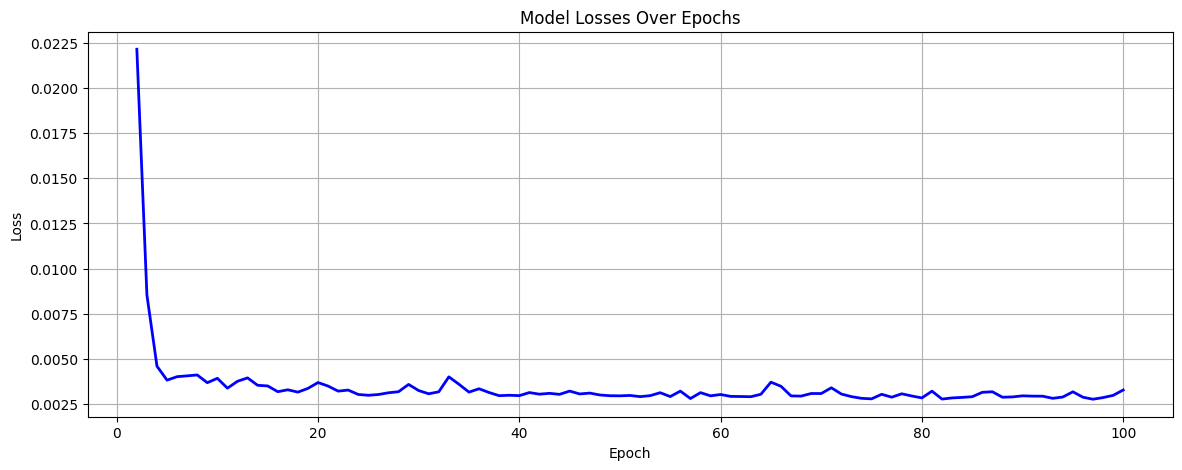

In [40]:
input_size = 1
hidden_size = 32

lstm_model = LSTMModel(input_size, hidden_size, output_size)

trained_lstm_model,lstm_losses = train(lstm_model, dataloader, learning_rate=0.01, epochs=epochs)
plot_loss(lstm_losses)

torch.Size([1, 221])
torch.Size([1000, 1])


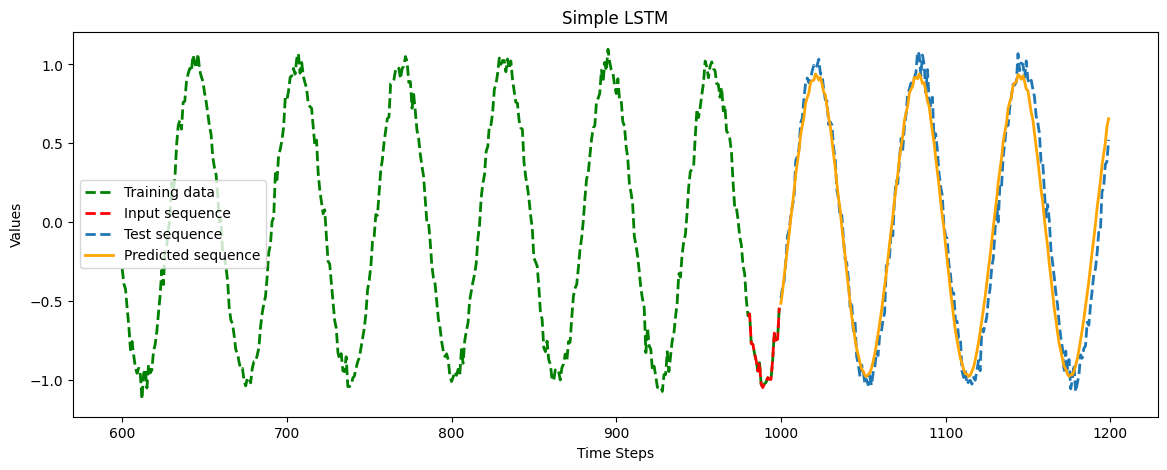

In [41]:
lstm_predictions, lstm_errors = evaluate_model(trained_lstm_model, train_data, input_sequence_len, future_steps,output_size)
plot_predictions(lstm_predictions,'Simple LSTM')

**Exercise 5**: Use multiple LSTM layer (use `num_layers` option)

In [45]:
class ImprovedLSTMModel(nn.Module):
    """
    Improved Long Short-Term Memory (LSTM) model class.

    Args:
    - input_size (int): Number of input features.
    - hidden_size (int): Number of hidden units in the LSTM layer.
    - output_size (int): Number of output features.
    - num_layers (int, optional): Number of LSTM layers. Default is 1.

    Attributes:
    - lstm (nn.LSTM): LSTM layer.
    - relu (nn.ReLU): ReLU activation function.
    - dropout (nn.Dropout): Dropout layer.
    - fc (nn.Linear): Fully connected layer for output.
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=1,dropout=0.0):
        super(ImprovedLSTMModel, self).__init__()
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True) #ajouter bidirectionnel pour avoir l'aller retour en paramèter de cette fonction
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        out, _ = self.lstm(x)
        out = self.relu(out)
        out = self.fc(out[:, -1, :])
        return out

100%|██████████| 100/100 [00:05<00:00, 19.43it/s]



Total time :5.2 s


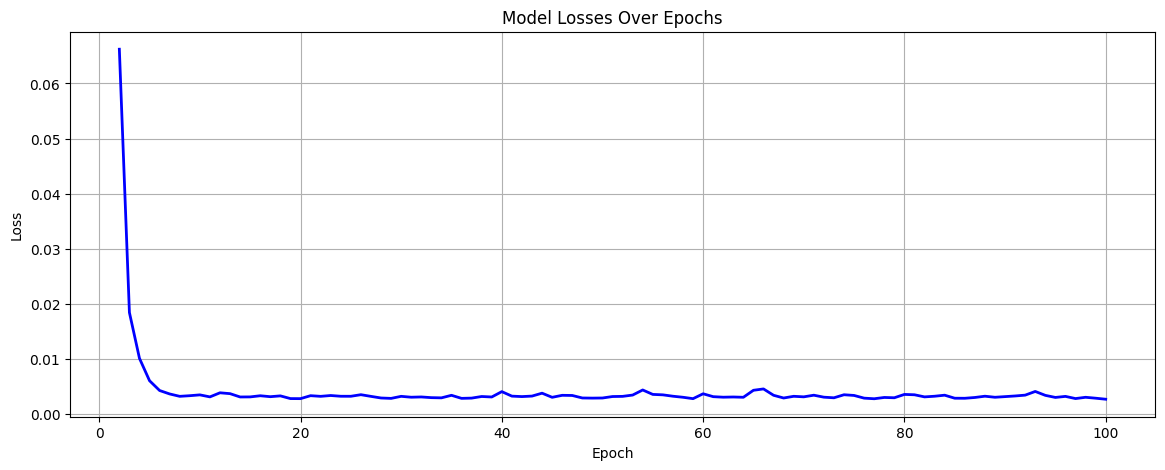

In [46]:
input_size = 1
hidden_size = 32
num_layers=5

lstm_model_2 = ImprovedLSTMModel(input_size, hidden_size, output_size,num_layers=num_layers)

trained_lstm_model_2,improved_lstm_losses = train(lstm_model_2, dataloader, learning_rate=0.01, epochs=epochs)
plot_loss(improved_lstm_losses)

torch.Size([1, 221])
torch.Size([1000, 1])


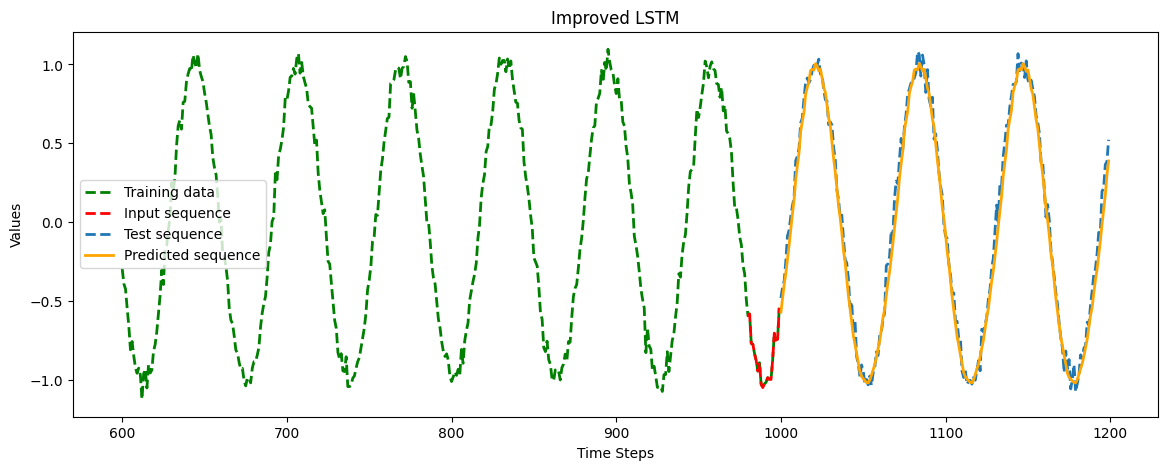

In [44]:
lstm_predictions_2, lstm_errors_2 = evaluate_model(trained_lstm_model_2, train_data, input_sequence_len, future_steps, output_size)
plot_predictions(lstm_predictions_2,'Improved LSTM')

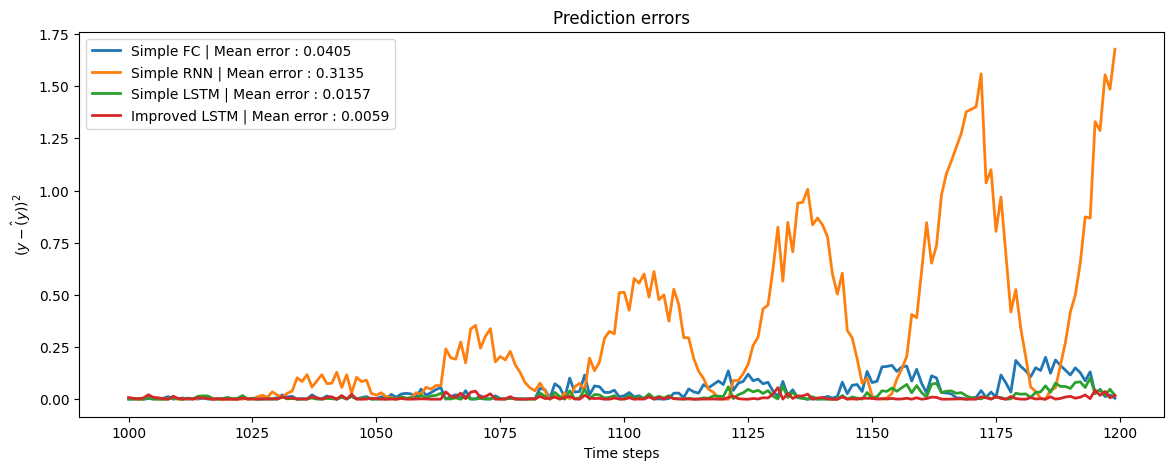

In [47]:
# Prediction errors comparison
plt.figure(figsize=(14,5))
plt.plot(range(len(train_data),len(train_data)+future_steps),fc_errors,
         label=f"Simple FC | Mean error : {np.mean(fc_errors):.4f}",linewidth=2)
plt.plot(range(len(train_data),len(train_data)+future_steps),rnn_errors,
         label=f"Simple RNN | Mean error : {np.mean(rnn_errors):.4f}",linewidth=2)
plt.plot(range(len(train_data),len(train_data)+future_steps),lstm_errors,
         label=f"Simple LSTM | Mean error : {np.mean(lstm_errors):.4f}",linewidth=2)
plt.plot(range(len(train_data),len(train_data)+future_steps),lstm_errors_2,
         label=f"Improved LSTM | Mean error : {np.mean(lstm_errors_2):.4f}",linewidth=2)
plt.legend()
plt.title("Prediction errors")
plt.xlabel("Time steps")
plt.ylabel("$(y-\hat(y))^2$")
plt.show()

# Training using real temperature data

## Data preparation

In [99]:
import pandas as pd
file_path = "/content/temp_pointe_du_raz.csv"
df = pd.read_csv(file_path)
df.head()

,date,temperature (Kelvin)
0,20070724000000,288.15
1,20070724010000,287.95
2,20070724020000,287.85
3,20070724030000,287.85
4,20070724040000,287.65


In [100]:
df['timestamp'] = pd.to_datetime(df['date'],format='%Y%m%d%H%M%S')
df.head()

,date,temperature (Kelvin),timestamp
0,20070724000000,288.15,2007-07-24 00:00:00
1,20070724010000,287.95,2007-07-24 01:00:00
2,20070724020000,287.85,2007-07-24 02:00:00
3,20070724030000,287.85,2007-07-24 03:00:00
4,20070724040000,287.65,2007-07-24 04:00:00


In [101]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df.head()

,date,temperature (Kelvin),timestamp,year,month,day,hour
0,20070724000000,288.15,2007-07-24 00:00:00,2007,7,24,0
1,20070724010000,287.95,2007-07-24 01:00:00,2007,7,24,1
2,20070724020000,287.85,2007-07-24 02:00:00,2007,7,24,2
3,20070724030000,287.85,2007-07-24 03:00:00,2007,7,24,3
4,20070724040000,287.65,2007-07-24 04:00:00,2007,7,24,4


In [102]:
# One-hot encoding
# >> tout va être 0 sauf la colonne concernée
#df_encoded = pd.get_dummies(df, columns=['month'])
# Alternatively, we use a cyclical encoding
df_encoded = df

# >> pour les transformer de manière cyclique, considérer le côté cyclique du temps 0h -> 1h -> 2h -> ... ->23h
df_encoded['month_sin'] = np.sin(2 * np.pi * df['month'] / 24)
df_encoded['month_cos'] = np.cos(2 * np.pi * df['month'] / 24)

df_encoded['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Kelvin to degrees celsius
df_encoded['unclean_temperature'] = df['temperature (Kelvin)'] - 273.15

# Normalise the temperatures into a range of [0, 1],
# to ensure that all input features are on a similar scale
min_temp = df_encoded['unclean_temperature'].min()
max_temp = df_encoded['unclean_temperature'].max()
df_encoded['unclean_temperature'] = (df_encoded['unclean_temperature'] - min_temp) / (max_temp - min_temp)

# normaliser la température pour assurer la stabilité du réseau

# Same for days
df_encoded['day'] = df_encoded['day']/31

# Remove unused columns
columns_to_drop = ['year','month','hour','date', 'timestamp' ,'temperature (Kelvin)']
df_encoded = df_encoded.drop(columns=columns_to_drop, axis=1)
df_encoded

,day,month_sin,month_cos,hour_sin,hour_cos,unclean_temperature
0,0.774194,0.965926,-0.258819,0.000000,1.000000,0.544669
1,0.774194,0.965926,-0.258819,0.258819,0.965926,0.538905
2,0.774194,0.965926,-0.258819,0.500000,0.866025,0.536023
3,0.774194,0.965926,-0.258819,0.707107,0.707107,0.536023
4,0.774194,0.965926,-0.258819,0.866025,0.500000,0.530259
...,...,...,...,...,...,...
140724,0.967742,0.500000,-0.866025,-0.866025,0.500000,0.524496
140725,0.967742,0.500000,-0.866025,-0.707107,0.707107,0.515850
140726,0.967742,0.500000,-0.866025,-0.500000,0.866025,0.510086
140727,0.967742,0.500000,-0.866025,-0.258819,0.965926,0.507205


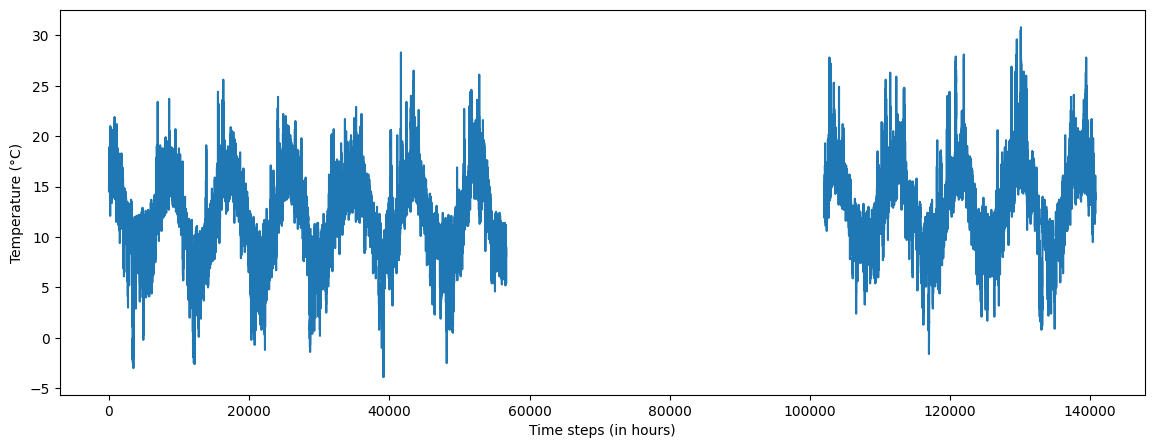

In [103]:
temp_data = np.array(df_encoded.unclean_temperature)*(max_temp - min_temp) + min_temp
plt.figure(figsize=(14,5))
plt.plot(temp_data)
plt.xlabel("Time steps (in hours)")
plt.ylabel("Temperature (°C)")
plt.show()

In [104]:
nan_indices = np.array(df_encoded.index[df_encoded.unclean_temperature.isna()])
print(nan_indices[:100]) # broken continuosly from index 56675
print("=====")
print(nan_indices[-100:]) # until 104083
nan_started = 56675
nan_stopped = 104083
other_missing_indices = np.arange(11122,11134)

[ 2236  9939 10122 10123 10124 11122 11123 11124 11125 11126 11127 11128
 11129 11130 11131 11132 11133 25170 25431 25432 25433 28772 56675 56676
 56677 56678 56679 56680 56681 56682 56683 56684 56685 56686 56687 56688
 56689 56690 56691 56692 56693 56694 56695 56696 56697 56698 56699 56700
 56701 56702 56703 56704 56705 56706 56707 56708 56709 56710 56711 56712
 56713 56714 56715 56716 56717 56718 56719 56720 56721 56722 56723 56724
 56725 56726 56727 56728 56729 56730 56731 56732 56733 56734 56735 56736
 56737 56738 56739 56740 56741 56742 56743 56744 56745 56746 56747 56748
 56749 56750 56751 56752]
=====
[103993 103994 103995 103996 103997 103998 103999 104000 104001 104002
 104003 104004 104005 104006 104007 104008 104009 104010 104011 104012
 104013 104014 104015 104016 104017 104018 104019 104020 104021 104022
 104023 104024 104025 104026 104027 104028 104029 104030 104031 104032
 104033 104034 104035 104036 104037 104038 104039 104040 104041 104042
 104043 104044 104045 104046 

In [105]:
subset_to_fill = df_encoded.loc[:nan_started, 'unclean_temperature']

# Fill missing values using the last valid observation
df_encoded['temperature'] = df_encoded["unclean_temperature"]
df_encoded.loc[:nan_started, 'temperature'] = subset_to_fill.ffill()

subset_to_fill = df_encoded.loc[nan_stopped:, 'unclean_temperature']
df_encoded.loc[nan_stopped:, 'temperature'] = subset_to_fill.ffill()

df_encoded.loc[nan_indices[:10]]
print(df_encoded.head())
df_encoded = df_encoded.drop(columns=['unclean_temperature'])
df_encoded.head()

        day  month_sin  month_cos  hour_sin  hour_cos  unclean_temperature  \
0  0.774194   0.965926  -0.258819  0.000000  1.000000             0.544669   
1  0.774194   0.965926  -0.258819  0.258819  0.965926             0.538905   
2  0.774194   0.965926  -0.258819  0.500000  0.866025             0.536023   
3  0.774194   0.965926  -0.258819  0.707107  0.707107             0.536023   
4  0.774194   0.965926  -0.258819  0.866025  0.500000             0.530259   

   temperature  
0     0.544669  
1     0.538905  
2     0.536023  
3     0.536023  
4     0.530259  


,day,month_sin,month_cos,hour_sin,hour_cos,temperature
0,0.774194,0.965926,-0.258819,0.000000,1.000000,0.544669
1,0.774194,0.965926,-0.258819,0.258819,0.965926,0.538905
2,0.774194,0.965926,-0.258819,0.500000,0.866025,0.536023
3,0.774194,0.965926,-0.258819,0.707107,0.707107,0.536023
4,0.774194,0.965926,-0.258819,0.866025,0.500000,0.530259


In [106]:
from pandas.core.dtypes import missing
class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for the time series data.
    """

    def __init__(self, dataframe, input_sequence_len, output_size=1, nan_started=56675, nan_stopped=104083, missing_indices=np.array([])):
        self.data = dataframe
        self.input_sequence_len = input_sequence_len
        self.output_size = output_size
        self.nan_started = nan_started
        self.missing_data_len = nan_stopped - nan_started
        self.missing_indices = missing_indices

    def __len__(self):
        return len(self.data) - 2*self.input_sequence_len - 2*self.output_size - self.missing_data_len

    def __getitem__(self, start_idx):
        stop_sequence_idx = start_idx + self.input_sequence_len
        stop_target_idx = stop_sequence_idx + self.output_size
        # If considered sequence intersects with the missing value list [11122, .... ,11133]
        # jump to 11134 index
        if np.intersect1d(np.arange(start_idx, stop_target_idx), self.missing_indices).size > 0:
          start_idx = self.missing_indices[-1] + 1

        # Avoid the missing data range
        if stop_target_idx >= self.nan_started :
            start_idx += self.missing_data_len + self.input_sequence_len + self.output_size
            stop_sequence_idx = start_idx + self.input_sequence_len
            stop_target_idx = stop_sequence_idx + self.output_size
        # Extracting a sequence of data
        # YOUR CODE HERE
        sequence = self.data.iloc[start_idx:stop_sequence_idx].values # récupérer les indices avec iloc et .values pour avoir la valeur (pas la dataframe)
        target = self.data.temperature.iloc[stop_sequence_idx:stop_target_idx].values  #target que la température
        # raise NotImplementedError()
        assert sequence.shape[0] == self.input_sequence_len
        assert target.shape[0] == self.output_size
        return {'sequence': torch.Tensor(sequence), 'target': torch.Tensor(target)}

In [107]:
split_at = -1000
train_df = df_encoded.iloc[:split_at]
test_df = df_encoded.iloc[split_at:]

input_sequence_len = 24 # Take the last 24 hours as an input sequence

output_size = 4 #4h de température
batch_size = 128

dataset = TimeSeriesDataset(train_df, input_sequence_len, output_size=output_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

sample_batch = next(iter(dataloader))

print(sample_batch['sequence'].shape)
print(sample_batch['target'].shape)

torch.Size([128, 24, 6])
torch.Size([128, 4])


## Model training

**Exercise 6**: Implement a model to predict the temperature over the 24 hours using the last 48 hours.

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 4])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([105, 4])) that is different to the input size (torch.Size([105, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 2/2 [01:13<00:00, 36.57s/it]



Total time :73.1 s


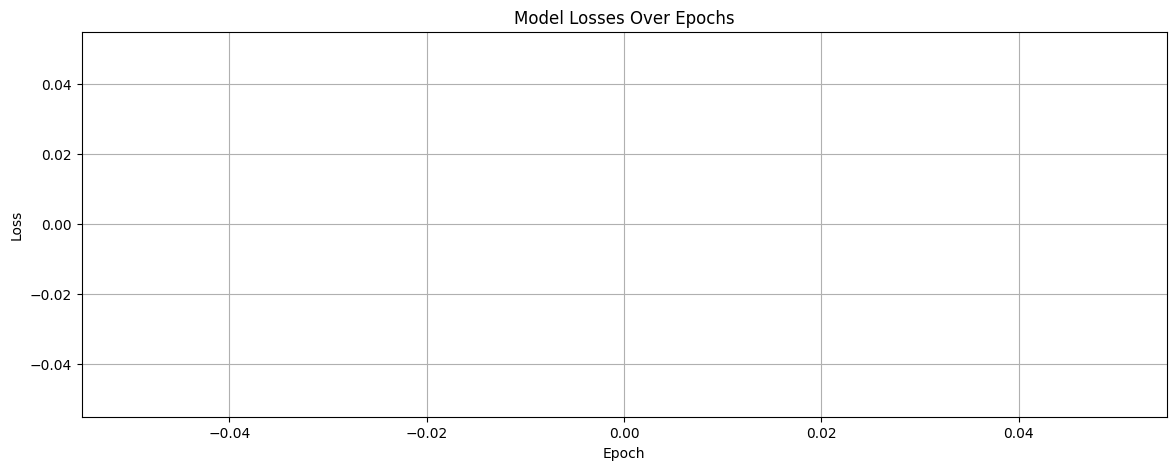

In [108]:
# YOUR CODE HERE
# raise NotImplementedError()

input_size = 6 #1 point = nb de colonnes (ici 6)
hidden_size = 64
output_size = 1
num_layers = 5
epochs = 2

lstm_model_3 = ImprovedLSTMModel(input_size, hidden_size, output_size, num_layers=num_layers)
trained_lstm_model_3, improved_lstm_losses_3 = train(lstm_model_3, dataloader, learning_rate=0.01, epochs=epochs)

## Testing

In [115]:
# YOUR CODE HERE
#raise NotImplementedError()

lstm_predictions_3, lstm_errors_3 = evaluate_model(trained_lstm_model_3, train_df.values, input_sequence_len, future_steps, output_size)
plot_predictions(lstm_predictions_3,'Improved LSTM')

TypeError: ignored

In [ ]:
future_steps = 2*24 # A prediction over the next 24 hours
# YOUR CODE HERE
raise NotImplementedError()

## Vanishing gradients
Vanishing gradients is a problem that can occur during the training of deep neural networks, particularly in recurrent neural networks (RNNs) and networks with many layers. It refers to the situation where the gradients of the loss function with respect to the parameters become extremely small, causing the weights to stop updating or updating very slowly during the training process.

The issue arises during the backpropagation algorithm, which is used to update the weights of the neural network based on the computed gradients. When the gradients become very small, the updates to the weights also become very small, and as a result, the weights may not change significantly, or they may converge to values where the network does not learn effectively.

Let's consider a simple feedforward neural network with multiple layers.

In a neural network, the weights are updated using the gradient descent optimization algorithm. The weights are adjusted in the opposite direction of the gradient of the loss function with respect to the weights. Mathematically, this can be expressed as:

$$ W_{ij}^{(l)} = W_{ij}^{(l)} - \alpha \frac{\partial L}{\partial W_{ij}^{(l)}} $$

where:
- $( W_{ij}^{(l)} )$ is the weight connecting neuron $(i)$ in layer $(l-1)$ to neuron $(j)$ in layer $(l)$.
- $( \alpha )$ is the learning rate.
- $( L )$ is the loss function.

The key factor that leads to vanishing gradients is the chain rule of calculus applied during backpropagation. The gradient of the loss with respect to the weights in layer $(l)$ is computed by recursively applying the chain rule:

$$ \frac{\partial L}{\partial W_{ij}^{(l)}} = \frac{\partial L}{\partial a_j^{(l)}} \cdot \frac{\partial a_j^{(l)}}{\partial W_{ij}^{(l)}} $$

where:
- $( a_j^{(l)} )$ is the input to neuron $(j)$ in layer $(l)$.

The vanishing gradient problem arises when the terms $( \frac{\partial L}{\partial a_j^{(l)}} )$ and $( \frac{\partial a_j^{(l)}}{\partial W_{ij}^{(l)}} )$ become very small for deep layers during the multiplication process.


Sometimes, this issue occurs with certain activation functions, such as the sigmoid or hyperbolic tangent (tanh), have saturating regions where the gradients become very small. In these regions, the derivatives of the functions approach zero, causing the gradients to vanish.
This happens due to the use of activation functions that saturate, such as the sigmoid or hyperbolic tangent (tanh).

Let's consider the sigmoid activation function as an example:

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

The derivative of the sigmoid function is:

$$ \sigma'(x) = \sigma(x) \cdot (1 - \sigma(x)) $$

In the context of the neural network formulation, if $( a_j^{(l)} )$ is large (positive or negative), the sigmoid function saturates, and its derivative becomes very close to zero. This small derivative gets multiplied with other small derivatives as we move backward through the layers during backpropagation, causing the overall gradient to vanish.